In [ ]:
!pip install easyocr
!pip install requests pandas

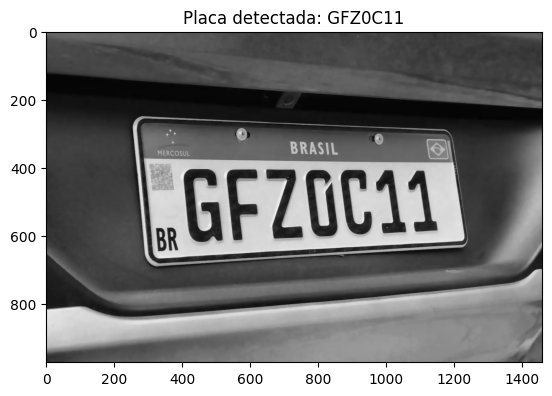

Informações da Placa:


,Chave,Valor
0,ano_fabricacao,2019
1,ano_modelo,2020
2,caixa_cambio,R9232A5248
3,cap_maxima_tracao,160
4,capacidade_carga,0
5,carroceria,NAO APLICAVEL
6,chassi,9BGEP76B0LB900086
7,cilindradas,1199
8,combustivel,ALCOOL / GASOLINA
9,cor,AZUL


In [36]:
import logging
import cv2
import matplotlib.pyplot as plt
import easyocr
import re
import requests
import pandas as pd

# Configurar o logger do easyocr para ignorar avisos
logging.getLogger('easyocr').setLevel(logging.ERROR)

# Inicializar o leitor EasyOCR
reader = easyocr.Reader(['pt'])

# Carregar a imagem
image = cv2.imread("a.jpg")

# Converter para escala de cinza
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Aplicar o CLAHE (Equalização adaptativa do histograma) para melhorar o contraste
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
enhanced_image = clahe.apply(gray)

# Aplicar filtro bilateral para preservar bordas
bilateral = cv2.bilateralFilter(enhanced_image, 11, 17, 17)

# Aplicar OCR na imagem aprimorada
results = reader.readtext(bilateral)

# Definir padrões de placas brasileiras antigas e novas
plate_pattern_old = r'^[A-Z]{3}\d{4}$'  # ABC1234
plate_pattern_new = r'^[A-Z]{3}\d{1}[A-Z]{1}\d{2}$'  # ABC1D23

# Função para corrigir 'O' para '0' quando necessário
def correct_plate_text(text):
    # Substituir 'O' por '0' apenas nos lugares apropriados para números
    text = list(text)
    for i, char in enumerate(text):
        if char == 'O':
            # Substituir 'O' por '0' em posições onde um número é esperado
            if i == 3 or (i >= 4 and text[i-1].isdigit()):  # Ex: 3ª posição em placas antigas ou após números
                text[i] = '0'
    return ''.join(text)

# Função para consultar a API e exibir o resultado em tabela zebrada
def consulta_placa(placa):
    url = f"https://placas.dados.in/?placa={placa}"
    response = requests.get(url)

    # Verificar se a resposta contém JSON válido
    try:
        data = response.json()  # Tentar converter para JSON
    except ValueError:
        print(f"Erro: a resposta da API não é um JSON válido. Resposta: {response.text}")
        return

    # Verificar se o retorno é uma lista com pelo menos um item
    if isinstance(data, list) and len(data) > 0:
        # Acessar o primeiro item da lista (que é o dicionário com as informações)
        vehicle_data = data[0]

        # Criar uma lista de tuplas (chave, valor) para exibir como tabela
        data_items = [(key, value) for key, value in vehicle_data.items()]

        # Criar um DataFrame a partir da lista de tuplas
        df = pd.DataFrame(data_items, columns=['Chave', 'Valor'])

        # Aplicar o estilo zebrado
        styled_df = df.style.apply(lambda x: ['background-color: lightgrey' if i % 2 == 0 else '' for i in range(len(x))], axis=0)

        print("Informações da Placa:")
        display(styled_df)  # Exibir o DataFrame zebrado
    else:
        print(f"Erro: a API retornou um dado inesperado ou vazio. Resposta: {data}")

# Iterar sobre os resultados e aplicar a regex
for (bbox, text, prob) in results:
    text = text.replace(" ", "")  # Remover espaços, caso OCR detecte espaços desnecessários

    # Corrigir o texto detectado substituindo 'O' por '0' quando apropriado
    corrected_text = correct_plate_text(text)

    if re.match(plate_pattern_old, corrected_text) or re.match(plate_pattern_new, corrected_text):

        # Mostrar a imagem com a placa detectada
        plt.imshow(cv2.cvtColor(bilateral, cv2.COLOR_BGR2RGB))
        plt.title(f"Placa detectada: {corrected_text}")
        plt.show()

        # Fazer a consulta na API para a placa detectada
        consulta_placa(corrected_text)
